In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Compute Bhattacharyya similarity (using histograms)
def compute_bhattacharyya(image1, image2):
    if len(image1.shape) == 3: #assumeixo que image1 i image2 tenen mateixa shape
        channels = image1.shape[-1]
    else:
        channels = 1


    hist1 = []
    hist2 = []
    # Get histograms
    for c in range(channels):
        hist1.append(cv2.calcHist([image1], [c], None, [256], (0,256)))
        hist2.append(cv2.calcHist([image2], [c], None, [256], (0,256)))

    # Compute Bhattacharyya distance between histograms
    bh_dist = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    # Return the Bhattacharyya similarity (1 - distance)
    return 1 - bh_dist

In [3]:
# Function to compute RMSE similarity between two images (directly on pixels)
def compute_rmse(image1, image2):
    # Convert images to float32 for precision
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    
    # Compute RMSE
    mse = np.mean((image1 - image2) ** 2)
    rmse = np.sqrt(mse)
    
    # Return RMSE as a similarity measure
    return rmse

In [4]:
import math

def compute_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [5]:
def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / (
        (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    )
    return ssim_map.mean()

def compute_ssim(img1, img2):
    """calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    """
    if not img1.shape == img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError("Wrong input image dimensions.")

In [6]:
#import piq
import lpips
import torch
import numpy as np

# Function to calculate LPIPS metric between two images
def compute_lpips(image1, image2, net='alex'):
    """
    Compute the LPIPS metric between two images.
    
    Parameters:
    - image1: First image as a NumPy array (H x W x C), where C is 3 for RGB.
    - image2: Second image as a NumPy array (H x W x C), where C is 3 for RGB.
    - net: The network architecture used for LPIPS computation ('alex', 'vgg', 'squeeze'). Default is 'alex'.
    
    Returns:
    - lpips_distance: The LPIPS distance between image1 and image2.
    """
    # Convert images from NumPy to PyTorch Tensors and normalize to [-1, 1]
    # (LPIPS expects inputs in the range [-1, 1] and in the format (N, C, H, W))
    image1_torch = torch.from_numpy(image1).permute(2, 0, 1).unsqueeze(0).float() / 127.5 - 1.0
    image2_torch = torch.from_numpy(image2).permute(2, 0, 1).unsqueeze(0).float() / 127.5 - 1.0

    # Initialize the LPIPS model (choose the backbone: 'alex', 'vgg', 'squeeze')
    loss_fn = lpips.LPIPS(net=net)

    # Calculate LPIPS distance
    lpips_distance = loss_fn(image1_torch, image2_torch)

    return lpips_distance.item()

In [7]:
def compare_images(image1, image2, method='bhattacharyya'):
    if method == 'bhattacharyya':
        return compute_bhattacharyya(image1, image2)
    elif method == 'rmse':
        return compute_rmse(image1, image2)
    elif method == 'psnr':
        return compute_psnr(image1, image2)
    elif method == 'ssim':
        return compute_ssim(image1, image2)
    elif method == 'lpips':
        return compute_lpips(image1, image2)
    else:
        raise ValueError(f"Unknown method: {method}. Choose 'bhattacharyya' or 'rmse'.")

In [8]:
image1 = cv2.imread('data/qsd1_w3/00005.jpg')
image2 = cv2.imread('data/qsd1_w3/non_augmented/00005.jpg')

compute_psnr(image1, image2), compute_ssim(image1, image2), compute_lpips(image1, image2) 

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\mirei\miniconda3\envs\c1-project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mirei\miniconda3\envs\c1-project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\mirei\miniconda3\envs\c1-project\Lib\site-packages\lpips\weights\v0.1\alex.pth


c:\Users\mirei\miniconda3\envs\c1-project\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map

(24.29165523734892, 0.5735294129751751, 0.6599388718605042)

In [9]:
#comprovació de que tinguin sentit tenint en compte: PSNR com més alt millor, SSIM com més aprop d 1 millor, LPIPS com més aprop d 0 millor
compute_psnr(image1, image1), compute_ssim(image1, image1), compute_lpips(image1, image1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\mirei\miniconda3\envs\c1-project\Lib\site-packages\lpips\weights\v0.1\alex.pth


(inf, 1.0, 0.0)

In [10]:
import cv2
import numpy as np
import os
import pandas as pd

# Function to convert images to the desired color space
def convert_color_space(image, color_space='RGB'):
    if color_space == 'RGB':
        return image
    elif color_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    elif color_space == 'GRAY':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"Unknown color space {color_space}")

# Directories containing the noisy images and the ground truth images
noisy_images_dir = 'data/qsd1_w3'
gt_images_dir = 'data/qsd1_w3/non_augmented'

# List to store results for each image
results = []

# User can choose the comparison method and color space
comparison_method = 'psnr'  # Choose 'bhattacharyya', 'rmse', 'psnr', 'ssim', 'lpips'
color_space = 'LAB'         # Choose 'RGB', 'HSV', 'LAB', or 'GRAY'

# Process all images in the folder
for img_name in os.listdir(noisy_images_dir):
    if img_name.endswith('.jpg') or img_name.endswith('.png'):
        # Load noisy image and corresponding ground truth image
        noisy_image_path = os.path.join(noisy_images_dir, img_name)
        gt_image_path = os.path.join(gt_images_dir, img_name)

        noisy_image = cv2.imread(noisy_image_path)
        gt_image = cv2.imread(gt_image_path)

        # Ensure both images are loaded correctly
        if noisy_image is None or gt_image is None:
            print(f"Error loading {img_name}")
            continue

        # Convert both images to the selected color space (only once)
        noisy_image_cs = convert_color_space(noisy_image, color_space=color_space)
        gt_image_cs = convert_color_space(gt_image, color_space=color_space)

        # Calculate similarity before filtering
        similarity_before = compare_images(noisy_image_cs, gt_image_cs, method=comparison_method)

        # Try different parameters for each filter

        # Gaussian Blur - Different kernel sizes
        gb_sims = []
        for k in [(3, 3), (5, 5), (7, 7)]:
            gb_img = cv2.GaussianBlur(noisy_image, k, 0)
            gb_sims.append((k, compare_images(gb_img, gt_image_cs, method=comparison_method)))
        
        # Median Blur - Different kernel sizes
        mb_sims = []
        for k in [3, 5, 7]:
            mb_img = cv2.medianBlur(noisy_image, k)
            mb_sims.append((k, compare_images(mb_img, gt_image_cs, method=comparison_method)))
        
        # Bilateral Filter - Different d, sigmaColor, sigmaSpace
        bb_sims = []
        for (d, sigma_color, sigma_space) in [(9, 75, 75), (9, 100, 100), (9, 150, 150)]:
            bb_img = cv2.bilateralFilter(noisy_image, d, sigma_color, sigma_space)
            bb_sims.append(((d, sigma_color, sigma_space), compare_images(bb_img, gt_image_cs, method=comparison_method)))

        # Non-Local Means (NLM) - Different h parameters
        nlm_sims = []
        for (h_luminance, h_color) in [(10, 10), (7, 21), (15, 15)]:
            nlm_img = cv2.fastNlMeansDenoisingColored(noisy_image, None, h_luminance, h_color, 7, 21)
            nlm_sims.append(((h_luminance, h_color), compare_images(nlm_img, gt_image_cs, method=comparison_method)))

        # Find the best parameters for each filter
        best_gb_sim = max(gb_sims, key=lambda x: x[1]) if comparison_method == 'bhattacharyya' else min(gb_sims, key=lambda x: x[1])
        best_mb_sim = max(mb_sims, key=lambda x: x[1]) if comparison_method == 'bhattacharyya' else min(mb_sims, key=lambda x: x[1])
        best_bb_sim = max(bb_sims, key=lambda x: x[1]) if comparison_method == 'bhattacharyya' else min(bb_sims, key=lambda x: x[1])
        best_nlm_sim = max(nlm_sims, key=lambda x: x[1]) if comparison_method == 'bhattacharyya' else min(nlm_sims, key=lambda x: x[1])

        # Store the results for this image
        results.append({
            'Image': img_name,
            'Similarity (Before)': similarity_before,
            'Best Gaussian Blur (Kernel)': best_gb_sim[0],
            'Gaussian Blur (Similarity)': best_gb_sim[1],
            'Best Median Blur (Kernel)': best_mb_sim[0],
            'Median Blur (Similarity)': best_mb_sim[1],
            'Best Bilateral Filter (Params)': best_bb_sim[0],
            'Bilateral Filter (Similarity)': best_bb_sim[1],
            'Best NLM (Params)': best_nlm_sim[0],
            'NLM (Similarity)': best_nlm_sim[1]
        })

# Convert results to a pandas DataFrame for better organization and analysis
df_results = pd.DataFrame(results)

# Optionally, save the results to a CSV file
df_results.to_csv(f'comparison_{color_space}_{comparison_method}_results.csv', index=False)

In [11]:
df_results

,Image,Similarity (Before),Best Gaussian Blur (Kernel),Gaussian Blur (Similarity),Best Median Blur (Kernel),Median Blur (Similarity),Best Bilateral Filter (Params),Bilateral Filter (Similarity),Best NLM (Params),NLM (Similarity)
0,00000.jpg,29.712994,"(3, 3)",13.477142,3,13.403613,"(9, 75, 75)",13.474319,"(7, 21)",13.414093
1,00000.png,inf,"(7, 7)",7.823469,7,7.823418,"(9, 150, 150)",7.822719,"(15, 15)",7.888167
2,00001.jpg,inf,"(3, 3)",14.764445,3,14.720989,"(9, 75, 75)",14.736745,"(7, 21)",14.665961
3,00001.png,inf,"(7, 7)",7.826254,7,7.825221,"(9, 150, 150)",7.824973,"(15, 15)",7.889319
4,00002.jpg,46.929465,"(3, 3)",9.597376,7,9.558886,"(9, 75, 75)",9.585042,"(15, 15)",9.524337
5,00002.png,inf,"(7, 7)",7.827008,7,7.825548,"(9, 150, 150)",7.825801,"(15, 15)",7.889275
6,00003.jpg,44.940637,"(3, 3)",15.843772,3,15.771921,"(9, 75, 75)",15.907678,"(7, 21)",15.761249
7,00003.png,inf,"(7, 7)",7.826582,7,7.826609,"(9, 150, 150)",7.825509,"(15, 15)",7.889850
8,00004.jpg,inf,"(3, 3)",12.666869,3,12.649648,"(9, 75, 75)",12.670995,"(10, 10)",12.632455
9,00004.png,inf,"(7, 7)",7.829490,7,7.813977,"(9, 150, 150)",7.825180,"(10, 10)",7.882747


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# gaussian_kernel_5x5 = (1.0/256)*np.array([[1, 4,  6,  4,  1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6],[4, 16, 24, 16, 4],[1, 4,  6,  4,  1]])
gaussian_kernel = (1.0/16)*np.array([[1, 2, 1],[2,4,2],[1,2,1]])

# Function to handle convolution of two images(matrices). Defining this as a general function helps 
# us in making repeated calls to the function in future.
def convolve(f, g):
    vmax = f.shape[0]
    wmax = f.shape[1]
    smax = g.shape[0]
    tmax = g.shape[1]
    smid = smax // 2
    tmid = tmax // 2
    xmax = vmax + 2*smid
    ymax = wmax + 2*tmid
    # Allocate result image.
    h = np.zeros([xmax, ymax], dtype=f.dtype)
    # Do convolution
    for x in range(xmax):
        for y in range(ymax):
            # Calculate pixel value for h at (x,y). Sum one component
            # for each pixel (s, t) of the filter g.
            s_from = max(smid - x, -smid)
            s_to = min((xmax - x) - smid, smid + 1)
            t_from = max(tmid - y, -tmid)
            t_to = min((ymax - y) - tmid, tmid + 1)
            value = 0
            for s in range(s_from, s_to):
                for t in range(t_from, t_to):
                    v = x - smid + s
                    w = y - tmid + t
                    value += g[smid - s, tmid - t] * f[v, w]
            h[x, y] = value
    return h

# Often the convolved image is not of the same size as the input image. The following function takes care of the 
# appropriate padding to ensure images are of same size before addition of subtraction.
def handle_img_padding(img1, img2):
    M1, N1 = img1.shape[:2]
    M2, N2 = img2.shape[:2]
    padding_x = int(np.abs(M2 - M1)/2)
    padding_y = int(np.abs(N2 - N1)/2)
    img2 = img2[padding_x:M1+padding_x, padding_y: N1+padding_y]
    return img2

# Function for upsampling of gaussian blur images.
def interpolate(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*gaussian_kernel)

# Function to perform Gaussian filtering on a given image. It convolves a given image with the Gaussian kernel 
# defined above and performs downsampling of the result.
def gaussian_pyramid_func(image):
    image_blur = convolve(image, gaussian_kernel)
    return image_blur[::2, ::2]

# Function to generate Gaussian and Laplacian pyramids using the method described above. Returns the generated
# Gaussian pyramid and Laplacian pyramid.
def create_gaussian_laplacian_pyramids(image, level):
    G = [image]
    L = []
    while level > 0:
        level -= 1
        image_blur = gaussian_pyramid_func(image)
        G.append(image_blur)
        expanded_img = interpolate(image_blur)
        if image.shape[:2] != expanded_img.shape[:2]:
            expanded_img = handle_img_padding(image, expanded_img)
        laplacian = image - expanded_img
        L.append(laplacian)
        image = image_blur
    return G, L

In [13]:
def preprocess_odd_images(img):
    M, N = img.shape[:2]
    if M % 2 == 1 and N % 2 == 1:
        return img[1:][1:]
    elif M%2 == 1:
        return img[1:][:]
    elif N%2 == 1:
        return img[:][1:]
    else:
        return img


In [14]:
original_img = cv2.imread('data/qsd1_w3/00005.jpg', 0)
original_img = preprocess_odd_images(original_img)

pyramid_levels = 6
gaussian_pyramid, laplacian_pyramid = create_gaussian_laplacian_pyramids(original_img, pyramid_levels)

In [15]:
# Functions to plot our results
def plot_input(img, title):
    plt.imshow(img, cmap = 'gray')
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

def sub_plot(img1, img2, img3, title):
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(img1, cmap = 'gray')
    plt.subplot(132)
    plt.imshow(img2, cmap = 'gray')
    plt.subplot(133)
    plt.imshow(img3, cmap = 'gray')
    plt.show()

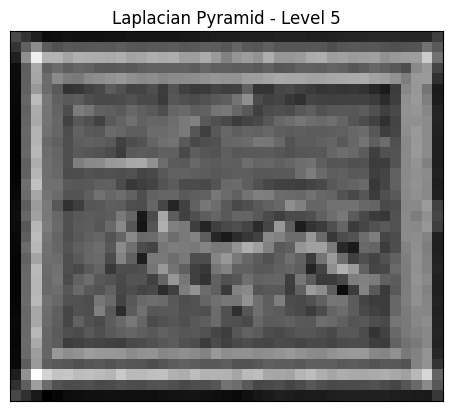

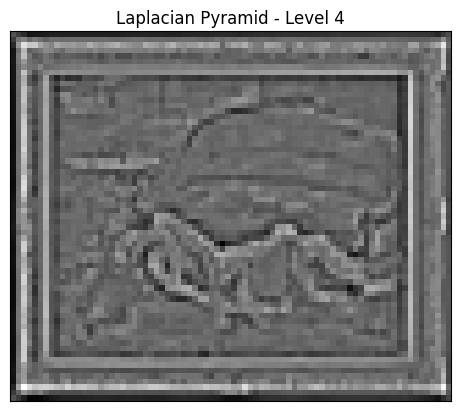

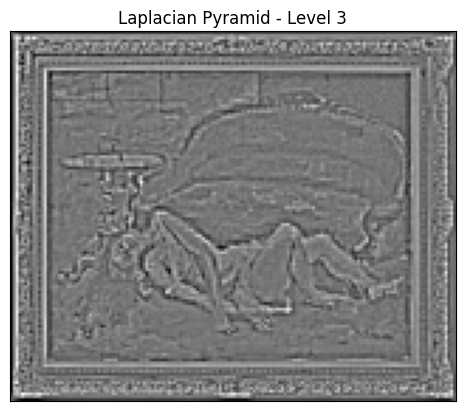

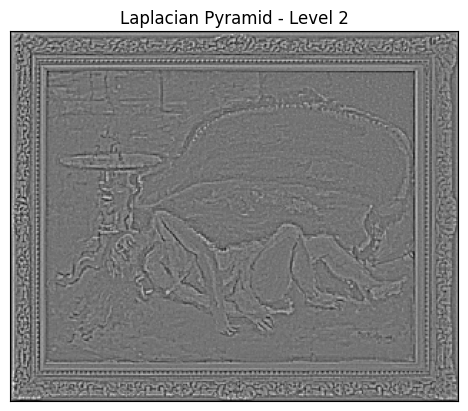

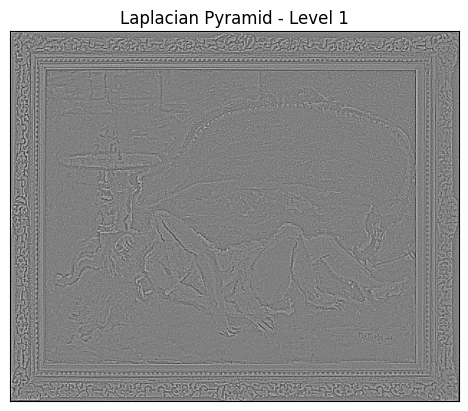

In [16]:
for i in range(len(laplacian_pyramid)-1, 0, -1):
    plot_input(laplacian_pyramid[i], 'Laplacian Pyramid - Level '+ str(i))

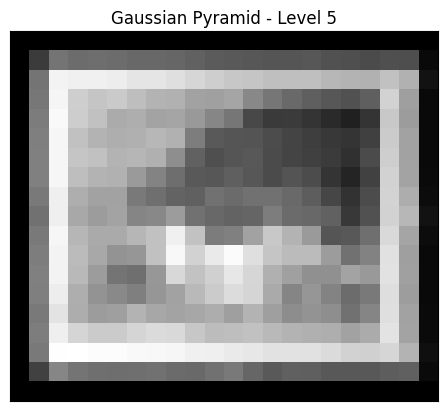

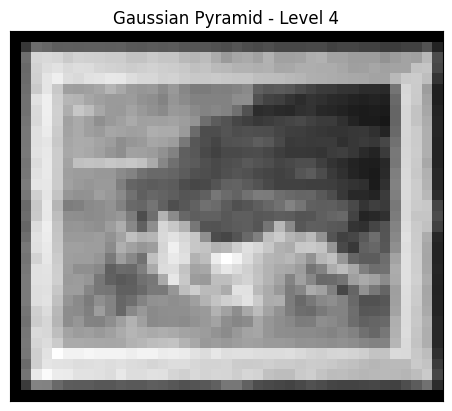

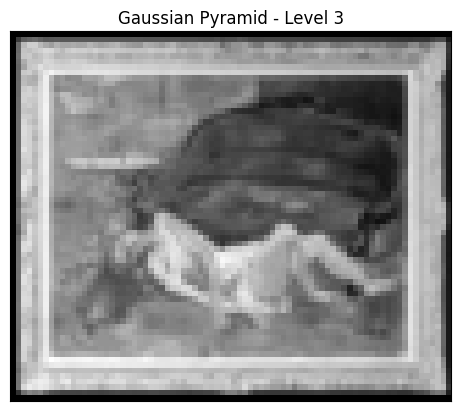

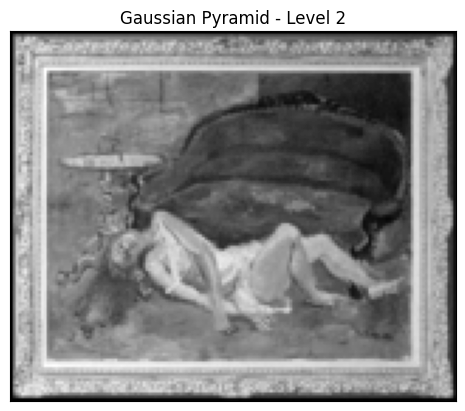

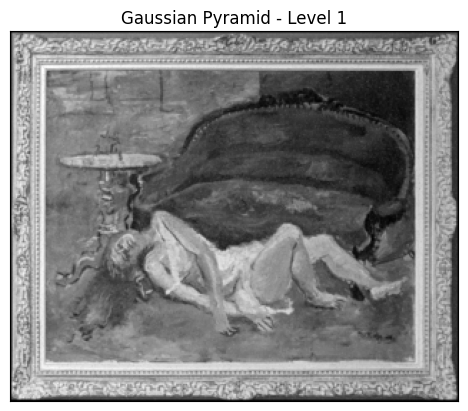

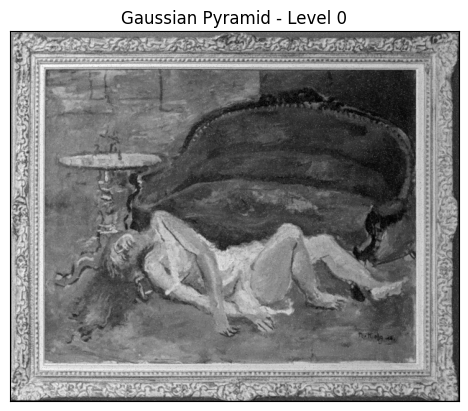

In [17]:
for i in range(len(gaussian_pyramid)-1, 0, -1):
    plot_input(gaussian_pyramid[i], 'Gaussian Pyramid - Level '+ str(i-1))

In [18]:
# Function to reconstruct original image using the computed Gaussian and Laplacian filters. 
# The function follows the steps described above for reconstruction of the image.
def reconstruct_original_img(G, L):
    reconstructed_images = []
    for i in range(len(G)-1 , 0, -1):
        expanded_img = interpolate(G[i])
        if expanded_img.shape[:2]!= L[i-1].shape[:2]:
            resized_img = handle_img_padding(L[i-1], expanded_img)
        reconstructed_images.append(resized_img + L[i-1])
        print("Levels" + str(i))
        sub_plot(expanded_img, L[i-1], resized_img + L[i-1], "Levels" + str(i))
    return reconstructed_images

Levels6


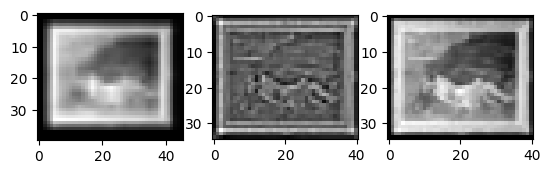

Levels5


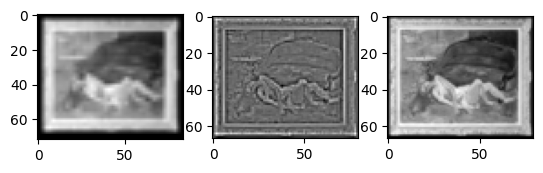

Levels4


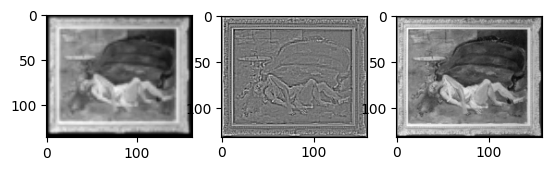

Levels3


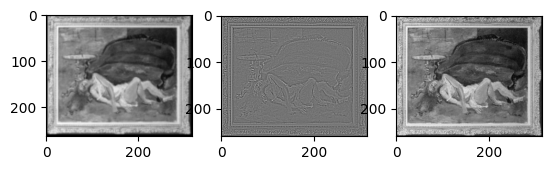

Levels2


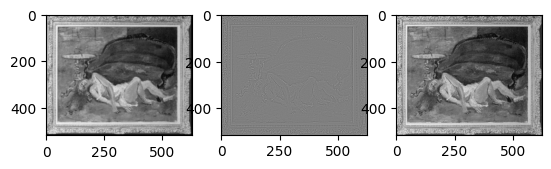

Levels1


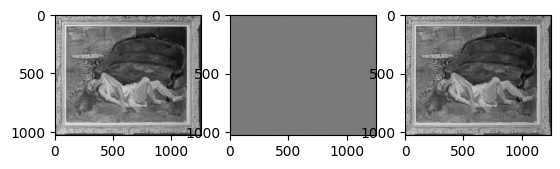

In [19]:
reconstructed_images = reconstruct_original_img(gaussian_pyramid, laplacian_pyramid)

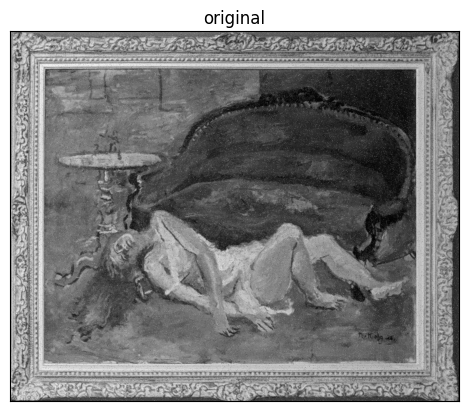

In [20]:
plot_input(original_img, 'original')

In [21]:
def create_gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def create_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid)-1, 0, -1):
        size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
        expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i-1], expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid


# Function to compute the desired similarity metric
def calculate_similarity(image1, image2, method='mse'):
    if method == 'mse':
        return np.mean((image1 - image2) ** 2)
    elif method == 'psnr':
        return compute_psnr(image1, image2)
    elif method == 'ssim':
        return compute_ssim(image1, image2)
    elif method == 'lpips':
        return compute_lpips(image1, image2)
    else:
        raise ValueError(f"Unknown method: {method}")

# Apply Gaussian, Median, Bilateral filters (same as before)
def apply_gaussian_filter(laplacian_pyramid, ksize):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.GaussianBlur(lap, (ksize, ksize), 0))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

def apply_median_filter(laplacian_pyramid, ksize):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.medianBlur(lap, ksize))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

def apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.bilateralFilter(lap, d, sigma_color, sigma_space))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

def reconstruct_image(laplacian_pyramid, gaussian_base):
    current_image = gaussian_base
    for laplacian in laplacian_pyramid:
        size = (laplacian.shape[1], laplacian.shape[0])
        current_image = cv2.pyrUp(current_image, dstsize=size)
        current_image = cv2.add(current_image, laplacian)
    return current_image

# Load an image
image = cv2.imread('data/qsd1_w3/00005.jpg', 0)  # Load a grayscale image
original_image = image.copy()
levels = 5

# Step 1: Create Gaussian and Laplacian Pyramids
gaussian_pyramid = create_gaussian_pyramid(image, levels)
laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)


# Choose comparison method
comparison_method = 'psnr'  # Choose 'mse', 'psnr', 'ssim', or 'lpips'

# Store the best result
best_denoised_image = None
best_method = None
best_params = None
best_similarity = float('-inf') if comparison_method in ['psnr', 'ssim'] else float('inf')

# Define different filters and parameters to try
# 1. Gaussian Filters
for ksize in [3, 5, 7]:
    denoised_laplacian_pyramid = apply_gaussian_filter(laplacian_pyramid, ksize)
    denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
    similarity = calculate_similarity(original_image, denoised_image, method=comparison_method)
    if (comparison_method in ['psnr', 'ssim'] and similarity > best_similarity) or \
       (comparison_method in ['mse', 'lpips'] and similarity < best_similarity):
        best_similarity = similarity
        best_denoised_image = denoised_image
        best_method = 'Gaussian'
        best_params = f'Kernel size: {ksize}'

# 2. Median Filters
for ksize in [3, 5, 7]:
    denoised_laplacian_pyramid = apply_median_filter(laplacian_pyramid, ksize)
    denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
    similarity = calculate_similarity(original_image, denoised_image, method=comparison_method)
    if (comparison_method in ['psnr', 'ssim'] and similarity > best_similarity) or \
       (comparison_method in ['mse', 'lpips'] and similarity < best_similarity):
        best_similarity = similarity
        best_denoised_image = denoised_image
        best_method = 'Median'
        best_params = f'Kernel size: {ksize}'

# 3. Bilateral Filters
for (d, sigma_color, sigma_space) in [(9, 75, 75), (9, 100, 100), (9, 150, 150)]:
    denoised_laplacian_pyramid = apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space)
    denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
    similarity = calculate_similarity(original_image, denoised_image, method=comparison_method)
    if (comparison_method in ['psnr', 'ssim'] and similarity > best_similarity) or \
       (comparison_method in ['mse', 'lpips'] and similarity < best_similarity):
        best_similarity = similarity
        best_denoised_image = denoised_image
        best_method = 'Bilateral'
        best_params = f'd: {d}, Sigma Color: {sigma_color}, Sigma Space: {sigma_space}'

# Output the best result
print(f'Best Method: {best_method}')
print(f'Best Params: {best_params}')
print(f'Best Similarity ({comparison_method.upper()}): {best_similarity}')

# Save the best denoised image
cv2.imwrite('best_denoised_image.jpg', best_denoised_image)


Best Method: Median
Best Params: Kernel size: 3
Best Similarity (PSNR): 19.057662491219954


True

### Grid search over Gaussian-Laplace Pyramids

In [22]:
noisy_images = []
gt_images = []

# Process all images in the folder
for img_name in os.listdir(noisy_images_dir):
    if img_name.endswith('.jpg'):
        # Load noisy image in RGB and corresponding ground truth image
        noisy_image_path = os.path.join(noisy_images_dir, img_name)
        gt_image_path = os.path.join(gt_images_dir, img_name)

        noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_COLOR)
        gt_image = cv2.imread(gt_image_path, cv2.IMREAD_COLOR)

        noisy_images.append(noisy_image)
        gt_images.append(gt_image)

In [23]:
# Store the results of each combination
results = []

# Define grid search ranges for parameters
levels_range = [3, 5, 7]  # Pyramid levels to test
gaussian_kernel_sizes = [3, 5, 7]  # Gaussian kernel sizes
median_kernel_sizes = [3, 5, 7]  # Median kernel sizes
bilateral_params = [(9, 75, 75), (9, 100, 100), (9, 150, 150)]  # Bilateral filter params (d, sigma_color, sigma_space)
comparison_method = 'ssim'  # Choose 'mse', 'psnr', 'ssim', or 'lpips'

In [24]:
from skimage.metrics import structural_similarity as ssim

# Function to compute similarity for RGB images
def calculate_similarity(image1, image2, method='ssim'):
    if method == 'mse':
        return np.mean((image1 - image2) ** 2)
    elif method == 'psnr':
        return cv2.PSNR(image1, image2)
    elif method == 'ssim':
        # Set win_size and channel_axis explicitly for multichannel images
        win_size = min(image1.shape[0], image1.shape[1], 7)  # Ensure win_size does not exceed the image size
        return ssim(image1, image2, win_size=win_size, channel_axis=-1)
    else:
        raise ValueError(f"Unknown method: {method}")

In [25]:
# Loop over the noisy and ground truth images in parallel
for noisy_image, gt_image in zip(noisy_images, gt_images):
    
    for levels in levels_range:
        # Step 1: Create Gaussian and Laplacian Pyramids
        gaussian_pyramid = create_gaussian_pyramid(noisy_image, levels)
        laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)
        
        # 1. Gaussian Filters
        for ksize in gaussian_kernel_sizes:
            denoised_laplacian_pyramid = apply_gaussian_filter(laplacian_pyramid, ksize)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Gaussian',
                'levels': levels,
                'kernel_size': ksize,
                'similarity': similarity
            })
        
        # 2. Median Filters
        for ksize in median_kernel_sizes:
            denoised_laplacian_pyramid = apply_median_filter(laplacian_pyramid, ksize)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Median',
                'levels': levels,
                'kernel_size': ksize,
                'similarity': similarity
            })
        
        # 3. Bilateral Filters
        for (d, sigma_color, sigma_space) in bilateral_params:
            denoised_laplacian_pyramid = apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Bilateral',
                'levels': levels,
                'd': d,
                'sigma_color': sigma_color,
                'sigma_space': sigma_space,
                'similarity': similarity
            })

In [26]:
# Create a DataFrame to store the results
df = pd.DataFrame(results)

# Save results to a CSV file for analysis
df.to_csv('denoising_grid_search_results.csv', index=False)

# Summarize results
best_result = df[df['similarity'] == df['similarity'].max()]
print(f'Best configuration:\n{best_result}')

Best configuration:
     method  levels  kernel_size  similarity   d  sigma_color  sigma_space
381  Median       3          3.0    0.930403 NaN          NaN          NaN


Although the maximum performance is achieved using Median, this seems to be an outlier. Gaussian seems to be slightly better in general.

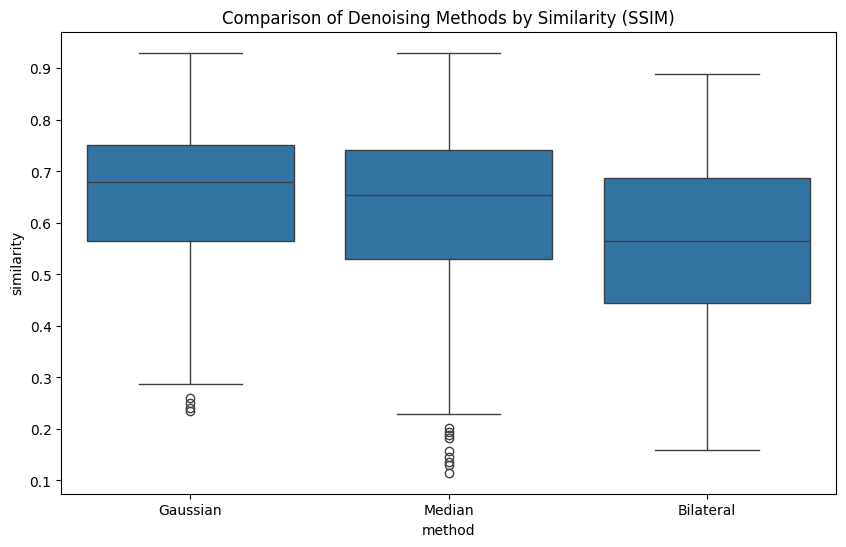

In [27]:
# Load the results from CSV
df = pd.read_csv('denoising_grid_search_results.csv')

# Plot similarity score for different filter methods
plt.figure(figsize=(10, 6))
sns.boxplot(x='method', y='similarity', data=df)
plt.title('Comparison of Denoising Methods by Similarity (SSIM)')
plt.show()


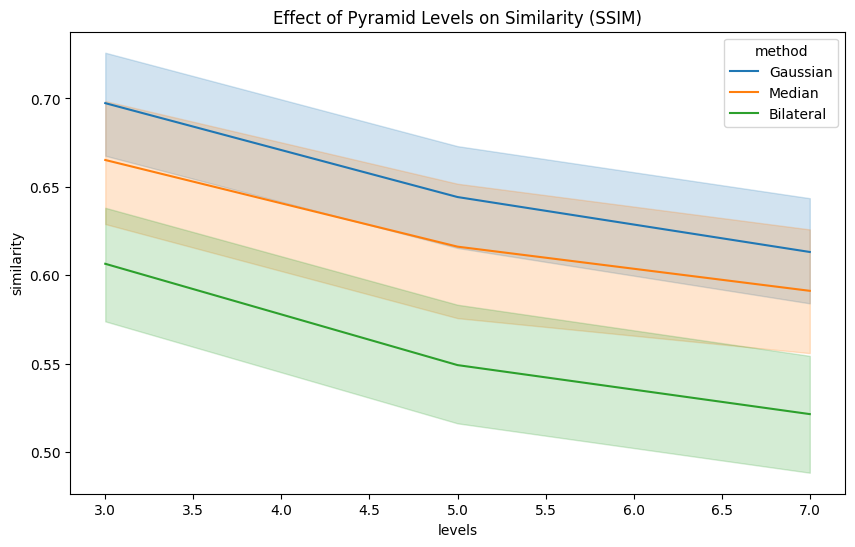

In [28]:
# Plot similarity score as a function of pyramid levels
# Seaborn: Passing the entire dataset in long-form mode will aggregate over repeated values (each year) to show the mean and 95% confidence interval
plt.figure(figsize=(10, 6))
sns.lineplot(x='levels', y='similarity', hue='method', data=df)
plt.title('Effect of Pyramid Levels on Similarity (SSIM)')
plt.show()

### Low-pass + High-pass filters

In [29]:
similarity_dict = {'original': [], 'gb': [], 'mb': [], 'bb': [], 'nlm': []}

for img, gt_img in zip(noisy_images, gt_images):

    gb_img = cv2.GaussianBlur(img, (5, 5), 0)
    mb_img = cv2.medianBlur(img, 5)
    bb_img = cv2.bilateralFilter(img, 9, 75, 75)
    nlm_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    for denoised_img, method in zip([img, gb_img, mb_img, bb_img, nlm_img], ['original', 'gb', 'mb', 'bb', 'nlm']):
        similarity = calculate_similarity(gt_img, denoised_img, comparison_method)
        print(f'{method}: {similarity}')
        similarity_dict[method].append(similarity)

original: 0.9538618092303027
gb: 0.8578986768451804
mb: 0.7853528784277798
bb: 0.8834120057387275
nlm: 0.8649338804874551
original: 1.0
gb: 0.9410396195825365
mb: 0.9071613585222988
bb: 0.8929532298456891
nlm: 0.8418472543342851
original: 0.9927218800143072
gb: 0.9519993899342487
mb: 0.9239938538360618
bb: 0.9278878915341254
nlm: 0.9394936650544025
original: 0.9936132619918391
gb: 0.9274312771081173
mb: 0.8609135415905809
bb: 0.8418375330564501
nlm: 0.7277427316634547
original: 1.0
gb: 0.9327387175553952
mb: 0.8962346794864781
bb: 0.8938980817571931
nlm: 0.85567879359691
original: 0.5863065329980667
gb: 0.8364842867080625
mb: 0.8097833504604224
bb: 0.7048614652819102
nlm: 0.7379569191180143
original: 0.7467856101052491
gb: 0.6345454599174307
mb: 0.457765007233409
bb: 0.7134203964066206
nlm: 0.7370349674516735
original: 0.9871671715148088
gb: 0.953646692215068
mb: 0.9522328146189469
bb: 0.9493417373173615
nlm: 0.9280238362920801
original: 1.0
gb: 0.95478516550426
mb: 0.9214895960377877


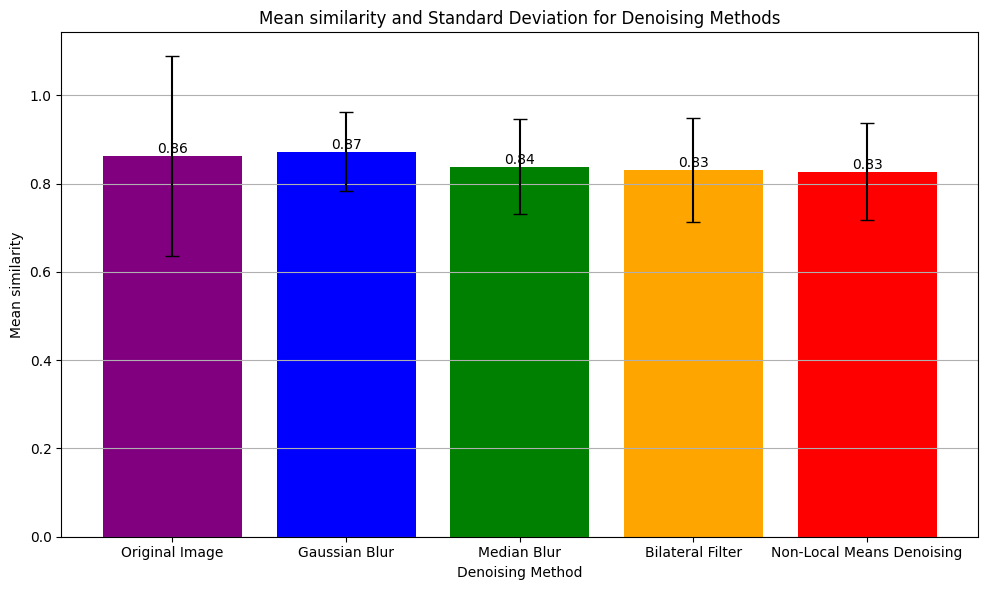

In [30]:
methods = list(similarity_dict.keys())
means = []
std_devs = []

# Calculate mean and standard deviation for each method
for method in methods:
    means.append(np.mean(similarity_dict[method]))
    std_devs.append(np.std(similarity_dict[method]))

method_names = {
    'original': 'Original Image',
    'gb': 'Gaussian Blur',
    'mb': 'Median Blur',
    'bb': 'Bilateral Filter',
    'nlm': 'Non-Local Means Denoising'
}

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, means, yerr=std_devs, capsize=5, color=['purple', 'blue', 'green', 'orange', 'red'])

plt.xlabel('Denoising Method')
plt.ylabel('Mean similarity')
plt.title('Mean similarity and Standard Deviation for Denoising Methods')

plt.xticks(ticks=range(len(methods)), labels=[method_names[method] for method in methods])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [32]:
similarity_dict = {
    'method': [],
    'levels': [],
    'kernel_size': [],
    'similarity': [],
    'd': [],
    'sigma_color': [],
    'sigma_space': []
}

# Configuration parameters
kernel_sizes = [3, 5, 7]  # Kernel sizes for Gaussian and Median filters
bilateral_params = [(9, 75, 75), (9, 100, 100), (9, 150, 150)]  # (d, sigma_color, sigma_space)

comparison_method = 'ssim'  # Change to your preferred metric (e.g., 'mse', 'psnr', 'ssim', 'lpips')

# Loop over each noisy image and its corresponding ground truth
for img, gt_img in zip(noisy_images, gt_images):

    # Test Gaussian Blur with different kernel sizes
    for ksize in kernel_sizes:
        gb_img = cv2.GaussianBlur(img, (ksize, ksize), 0)
        similarity = calculate_similarity(gt_img, gb_img, comparison_method)
        similarity_dict['method'].append('Gaussian')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Gaussian
        similarity_dict['kernel_size'].append(ksize)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(np.nan)
        similarity_dict['sigma_color'].append(np.nan)
        similarity_dict['sigma_space'].append(np.nan)
    
    # Test Median Blur with different kernel sizes
    for ksize in kernel_sizes:
        mb_img = cv2.medianBlur(img, ksize)
        similarity = calculate_similarity(gt_img, mb_img, comparison_method)
        similarity_dict['method'].append('Median')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Median
        similarity_dict['kernel_size'].append(ksize)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(np.nan)
        similarity_dict['sigma_color'].append(np.nan)
        similarity_dict['sigma_space'].append(np.nan)

    # Test Bilateral Filter with different parameters
    for (d, sigma_color, sigma_space) in bilateral_params:
        bb_img = cv2.bilateralFilter(img, d, sigma_color, sigma_space)
        similarity = calculate_similarity(gt_img, bb_img, comparison_method)
        similarity_dict['method'].append('Bilateral')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Bilateral
        similarity_dict['kernel_size'].append(np.nan)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(d)
        similarity_dict['sigma_color'].append(sigma_color)
        similarity_dict['sigma_space'].append(sigma_space)

    # Test Non-Local Means Denoising (NLM)
    nlm_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    similarity = calculate_similarity(gt_img, nlm_img, comparison_method)
    similarity_dict['method'].append('NLM')
    similarity_dict['levels'].append(np.nan)  # Not applicable for NLM
    similarity_dict['kernel_size'].append(np.nan)
    similarity_dict['similarity'].append(similarity)
    similarity_dict['d'].append(np.nan)
    similarity_dict['sigma_color'].append(np.nan)
    similarity_dict['sigma_space'].append(np.nan)

# Convert results to a DataFrame
results_df = pd.DataFrame(similarity_dict)

# Save the results to a CSV file
results_df.to_csv('denoising_results.csv', index=False)

print("Denoising results saved to 'denoising_results.csv'.")


Denoising results saved to 'denoising_results.csv'.


: 

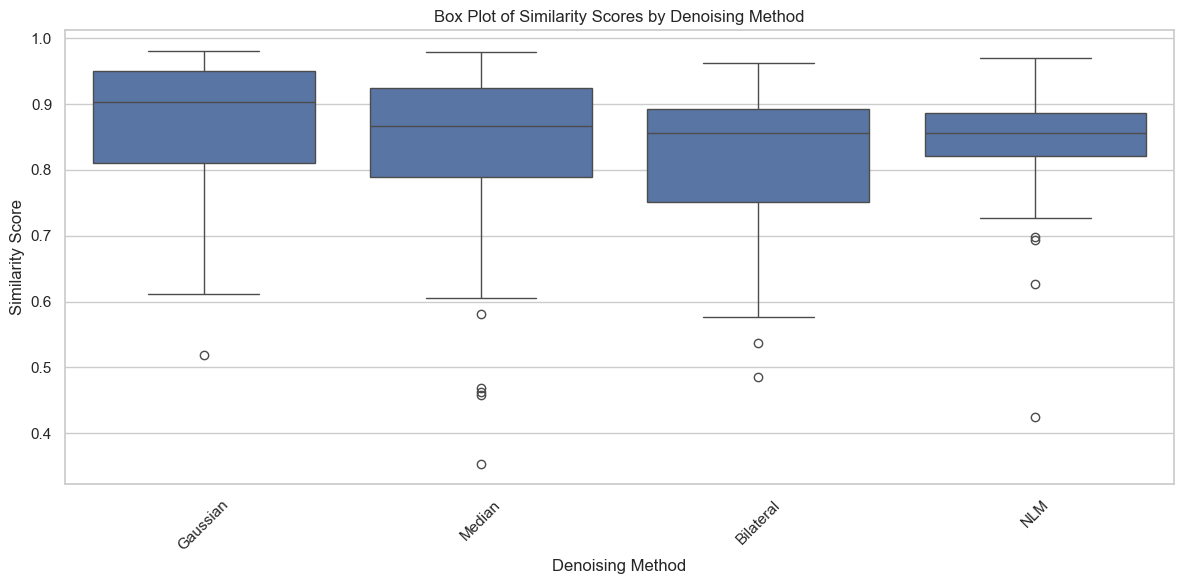

C:\Users\mirei\AppData\Local\Temp\ipykernel_15680\2609214319.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='similarity', data=mean_scores, palette='viridis')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load results from the CSV file
results_df = pd.read_csv('denoising_results.csv')

# Set seaborn style
sns.set(style='whitegrid')

# Box Plot for Similarity Scores by Method
plt.figure(figsize=(12, 6))
sns.boxplot(x='method', y='similarity', data=results_df)
plt.title('Box Plot of Similarity Scores by Denoising Method')
plt.xlabel('Denoising Method')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('box_plot_similarity_scores.png')  # Save the figure
plt.show()

# Bar Plot for Mean Similarity Scores by Method
mean_scores = results_df.groupby('method')['similarity'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='method', y='similarity', data=mean_scores, palette='viridis')
plt.title('Mean Similarity Scores by Denoising Method')
plt.xlabel('Denoising Method')
plt.ylabel('Mean Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mean_similarity_scores.png')  # Save the figure
plt.show()

# Pairwise Comparison of Similarity Scores
# This plot shows the distribution of similarity scores for each method
plt.figure(figsize=(12, 8))
sns.violinplot(x='method', y='similarity', data=results_df, inner='quartile', palette='muted')
plt.title('Violin Plot of Similarity Scores by Denoising Method')
plt.xlabel('Denoising Method')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('violin_plot_similarity_scores.png')  # Save the figure
plt.show()


In [31]:
def high_pass_filter(image, ksize=5):
    """Apply a high-pass filter to the image."""
    # Apply a Gaussian blur to get low-frequency components
    low_pass = cv2.GaussianBlur(image, (ksize, ksize), 0)
    # Subtract low-frequency components from the original image
    high_pass = cv2.subtract(image, low_pass)
    return high_pass

def enhance_image_with_hp(denoised_image, ksize=5):
    """Enhance the denoised image using high-pass filtering."""
    high_pass_details = high_pass_filter(denoised_image, ksize)
    # Add high-frequency details back to the denoised image
    enhanced_image = cv2.add(denoised_image, high_pass_details)
    return enhanced_image


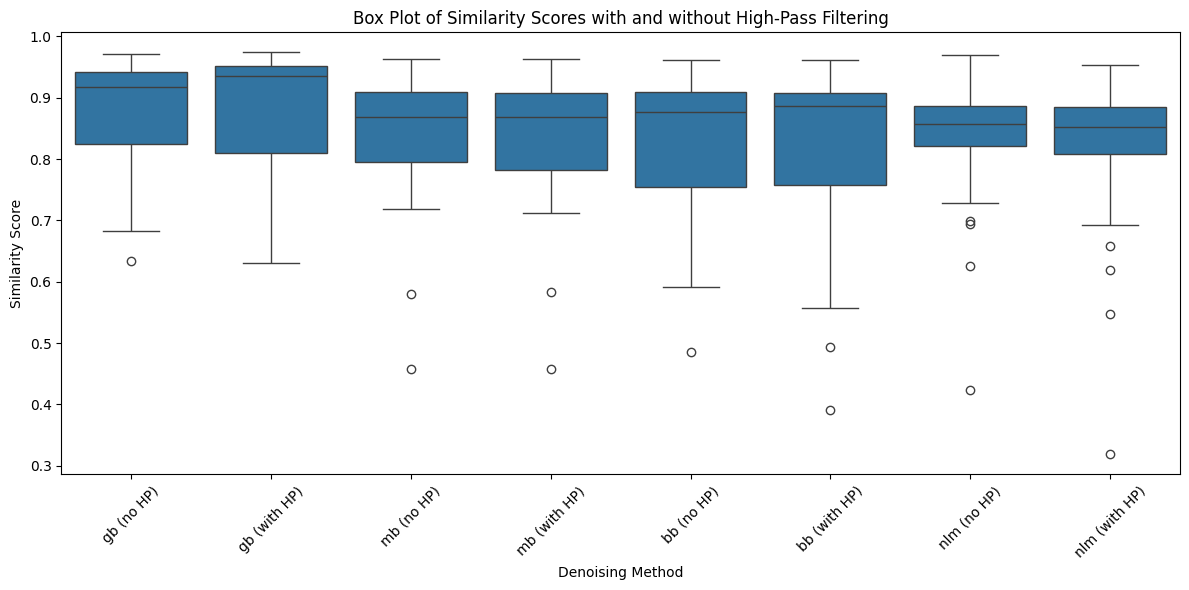

In [32]:
# Define a function to analyze similarity with and without high-pass filtering
def analyze_high_pass_filtering(noisy_images, gt_images, comparison_method='ssim'):
    similarity_dict = {'method': [], 'similarity': []}

    for img, gt_img in zip(noisy_images, gt_images):
        # Apply different denoising methods
        denoised_images = {
            'gb': cv2.GaussianBlur(img, (5, 5), 0),
            'mb': cv2.medianBlur(img, 5),
            'bb': cv2.bilateralFilter(img, 9, 75, 75),
            'nlm': cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        }

        # Analyze each method with and without high-pass filtering
        for method, denoised_img in denoised_images.items():
            # Calculate similarity without high-pass filtering
            similarity_no_hp = calculate_similarity(gt_img, denoised_img, method=comparison_method)
            similarity_dict['method'].append(f"{method} (no HP)")
            similarity_dict['similarity'].append(similarity_no_hp)

            # Enhance using high-pass filtering
            enhanced_img = enhance_image_with_hp(denoised_img, ksize=5)

            # Calculate similarity with high-pass filtering
            similarity_hp = calculate_similarity(gt_img, enhanced_img, method=comparison_method)
            similarity_dict['method'].append(f"{method} (with HP)")
            similarity_dict['similarity'].append(similarity_hp)

    return pd.DataFrame(similarity_dict)

# Run the analysis
comparison_method = 'ssim'  # or 'psnr', etc.
results_hp_analysis = analyze_high_pass_filtering(noisy_images, gt_images, comparison_method)

# Save results to CSV
results_hp_analysis.to_csv('high_pass_filtering_results.csv', index=False)

# Visualize results
plt.figure(figsize=(12, 6))
sns.boxplot(x='method', y='similarity', data=results_hp_analysis)
plt.title('Box Plot of Similarity Scores with and without High-Pass Filtering')
plt.xlabel('Denoising Method')
plt.ylabel('Similarity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('hp_filtering_box_plot.png')
plt.show()
